<a href="https://colab.research.google.com/github/QuiNhu/Tomato_Disease_Detection/blob/main/Tomato_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
!unzip /content/drive/MyDrive/Tomato_leaf_diseases_detection/archive.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/tomato/train/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG  
  inflating: /content/tomato/train/Tomato___Target_Spot/0044d10f-7062-4655-8abd-9fffc5b2f152___Com.G_TgS_FL 7908.JPG  
  inflating: /content/tomato/train/Tomato___Target_Spot/00854623-ba28-446d-a1d5-03c0ae3f99d9___Com.G_TgS_FL 7949.JPG  
  inflating: /content/tomato/train/Tomato___Target_Spot/0118c27a-f34a-41e1-8b2f-d2c564f83c5c___Com.G_TgS_FL 0013.JPG  
  inflating: /content/tomato/train/Tomato___Target_Spot/0118ed61-b135-45be-ad81-7e2d54203be4___Com.G_TgS_FL 8241.JPG  
  inflating: /content/tomato/train/Tomato___Target_Spot/0197df47-a9cb-4b6c-b72c-ac0e9af6d135___Com.G_TgS_FL 0779.JPG  
  inflating: /content/tomato/train/Tomato___Target_Spot/025510ac-15db-4861-b02b-21da82161100___Com.G_TgS_FL 0952.JPG  
  inflating: /content/tomato/train/Tomato___Target_Spot/0288164e-d6cf-4215-b593-7b581308a4cf___Com.G_TgS_FL 9777.JPG

In [7]:
# Set paths to train and validation folders
train_path = "/content/tomato/train"
valid_path = "/content/tomato/val"

In [8]:
# Define image data generators with data augmentation
image_size = (224, 224) # 244 x 244 pixel
batch_size = 32 # the number of images processed in each training iteration
train_datagen = ImageDataGenerator( # augmenting and preprocessing training images
    rescale=1.0/255, # scaling pixel values to range [0, 1]
    rotation_range=45, # randomly rotating images by up to 45 degrees
    width_shift_range=0.4, # shifting image horizontally by up to 40% of image w.
    height_shift_range=0.4, # shifting image vertically by up to 40% of image h.
    shear_range=0.4, # shear tranformations
    zoom_range=0.4, # zooming in or out on images by up to 40%.
    horizontal_flip=True # flipping images horizontally
)

In [9]:
valid_datagen = ImageDataGenerator(
    rescale=1.0/255 # re-scaling pixel values to normal range
    )

In [10]:
# Data Generators for Training Data
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 10000 images belonging to 10 classes.


In [11]:
# Data Generators for Valid Data
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 1000 images belonging to 10 classes.


In [12]:
# Display random Images from Dataset Subfolders.
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_random_images(directory, num_images=9, num_columns=3):
    """
    - directory: where the dataset subfolders are located.
    - num_images: number of random images to display (optional, default = 9).
    - num_columns: number of columns in the display grid (opional, default = 3).
    """
    # identifies subfolders within directory.
    subfolders = [subfolder for subfolder in os.listdir(directory) if os.path.isdir(os.path.join(directory, subfolder))]
    if len(subfolders) == 0:
        print(f"No subfolders found in {directory}")
        return
    # randomly selects one of these subfolder.
    random_subfolder = random.choice(subfolders)
    subfolder_path = os.path.join(directory, random_subfolder)

    # lists the image files within chosen subfolders.
    image_files = [filename for filename in os.listdir(subfolder_path) if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(image_files) < num_images:
        print(f"Number of available images in {subfolder_path} is less than {num_images}")
        return
    # randomly select num_images from the available images.
    random_files = random.sample(image_files, num_images)
    num_rows = (num_images + num_columns - 1) // num_columns
    plt.figure(figsize=(15, 10))

    # create a gird for displaying the selected images
    for i, filename in enumerate(random_files):
        img_path = os.path.join(subfolder_path, filename)
        img = mpimg.imread(img_path)
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(filename)

    # displays the images with their filenames
    plt.tight_layout()
    plt.show()

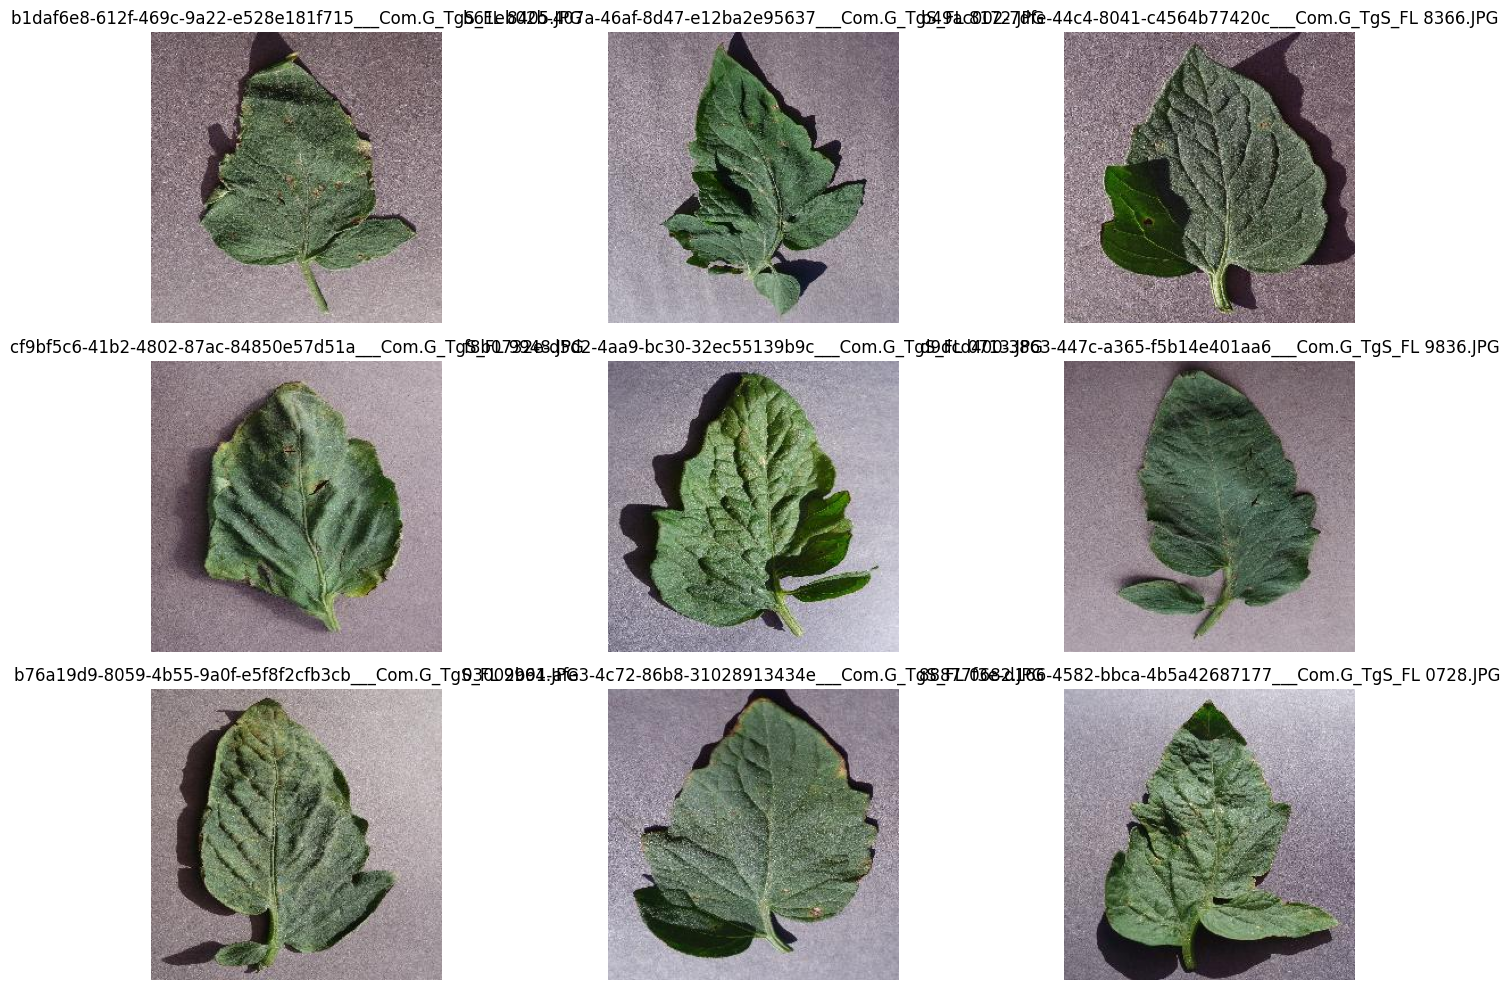

In [13]:
# Call the function with the desired directory and number of images
display_random_images(train_path, num_images=9, num_columns=3)

In [14]:
# Create a CNN model
num_classes = len(train_generator.class_indices) # num of disease types in training data
model = Sequential([
    # 1st Conv - extract features form input images.
    Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    # 1st MaxPooling - reduces spatial dimensions and retain important features.
    MaxPooling2D(2, 2),
    # 2nd Conv
    Conv2D(64, (3, 3), activation="relu"),
    # 2nd MaxPooling
    MaxPooling2D(2, 2),
    # flattens the output from the previous layers into a one-dimensional vector.
    Flatten(),
    # fully connected layer - 128 neurons and ReLU activation
    Dense(128, activation="relu"),
    # Dropot layer - rate = 50% - preventing overfitting by randomly deactivating neurons during training.
    Dropout(0.5),
    # fully connected layer - produces class probabilities for each category.
    Dense(num_classes, activation="softmax")
])

In [15]:
from tensorflow.keras.optimizers import Adam

# Compile the model with Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.001),  # updating the model's weights during training to minimize the loss function.
    loss="categorical_crossentropy", # because this is a multi-class classification problem
    metrics=["accuracy"]
)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs=100,
    validation_data = valid_generator,
    validation_steps = len(valid_generator),
    callbacks = [early_stopping]  # Add the EarlyStopping callback
)

Epoch 1/100
313/313 [==============================] - 165s 483ms/step - loss: 2.2094 - accuracy: 0.2252 - val_loss: 1.7522 - val_accuracy: 0.2990
Epoch 2/100
313/313 [==============================] - 152s 486ms/step - loss: 1.8245 - accuracy: 0.3404 - val_loss: 1.4382 - val_accuracy: 0.4570
Epoch 3/100
313/313 [==============================] - 150s 479ms/step - loss: 1.5900 - accuracy: 0.4277 - val_loss: 1.8588 - val_accuracy: 0.4020
Epoch 4/100
313/313 [==============================] - 151s 483ms/step - loss: 1.4490 - accuracy: 0.4837 - val_loss: 1.2717 - val_accuracy: 0.5300
Epoch 5/100
313/313 [==============================] - 153s 487ms/step - loss: 1.3154 - accuracy: 0.5302 - val_loss: 1.1611 - val_accuracy: 0.5840
Epoch 6/100
313/313 [==============================] - 152s 486ms/step - loss: 1.2455 - accuracy: 0.5460 - val_loss: 1.1558 - val_accuracy: 0.5820
Epoch 7/100
313/313 [==============================] - 151s 483ms/step - loss: 1.1273 - accuracy: 0.5960 - val_loss: 0

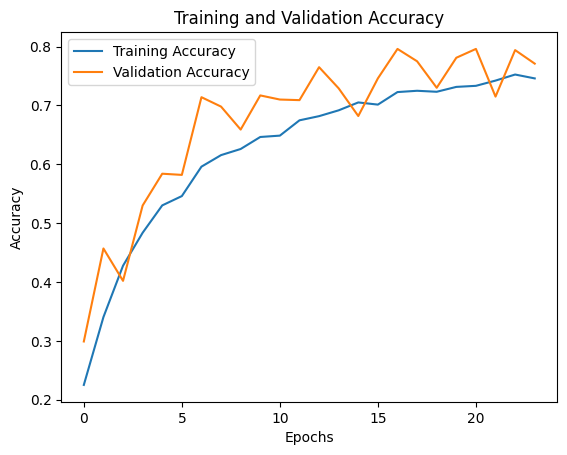

In [17]:
# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

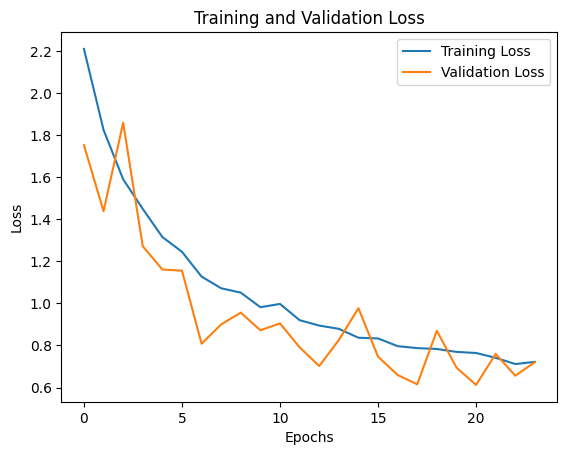

In [18]:
# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [19]:
# Make predictions on test data
test_loss, test_accuracy = model.evaluate(valid_generator, steps=len(valid_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the trained model
model.save("tomato_disease_detection_v1.h5")
print("Trained model saved as 'tomato_disease_detection_v1.h5'")

32/32 [==============================] - 2s 55ms/step - loss: 0.6598 - accuracy: 0.7960
Test Loss: 0.6598
Test Accuracy: 0.7960
Trained model saved as 'tomato_disease_detection_v1.h5'


1/1 [==============================] - 0s 73ms/step


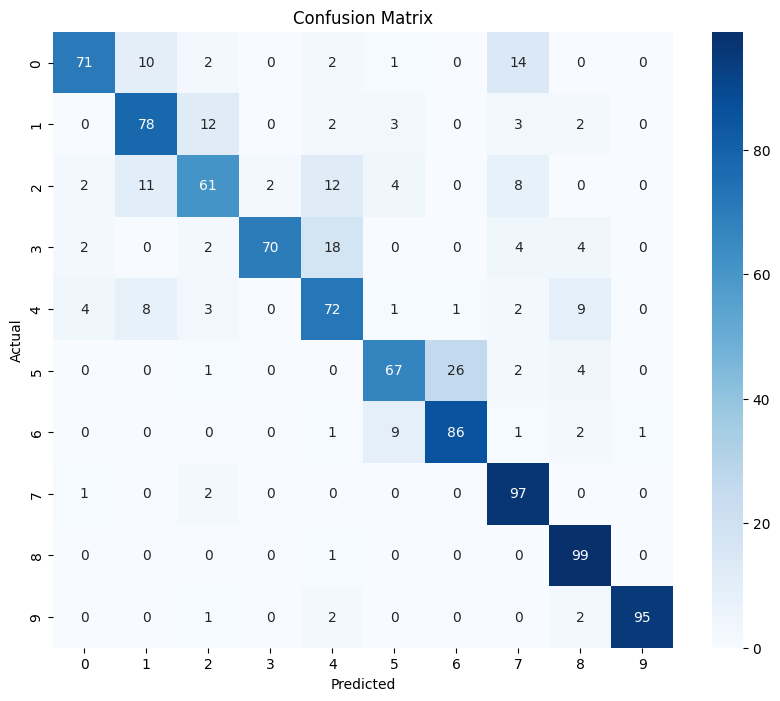

In [20]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
# Load the saved model
loaded_model = tf.keras.models.load_model("tomato_disease_detection_v1.h5")

# Initialize variables
num_samples = len(valid_generator.filenames)
batch_size = 32
num_batches = int(np.ceil(num_samples / batch_size))
all_test_labels = []
all_predicted_labels = []

# Generate predictions in batches
for _ in range(num_batches):
    batch_images, batch_labels = next(valid_generator)
    batch_predictions = loaded_model.predict(batch_images)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)

    all_test_labels.extend(np.argmax(batch_labels, axis=1))
    all_predicted_labels.extend(batch_predicted_labels)

# Generate confusion matrix
cm = confusion_matrix(all_test_labels, all_predicted_labels)

# Plot the confusion matrix
class_names = [str(i) for i in range(num_classes)]  # Replace with actual class names if available
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()